In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [4]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('barrios.geojson') # No me cargaba el link asi que me paso el archivo un compañero

## Visualización

<Axes: >

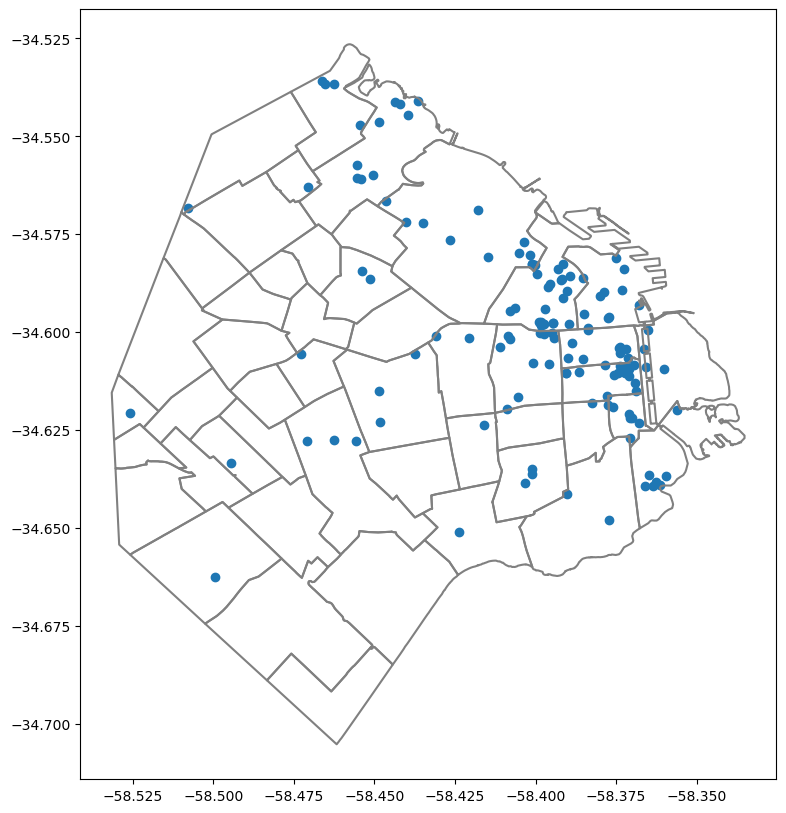

In [6]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [8]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [10]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [12]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

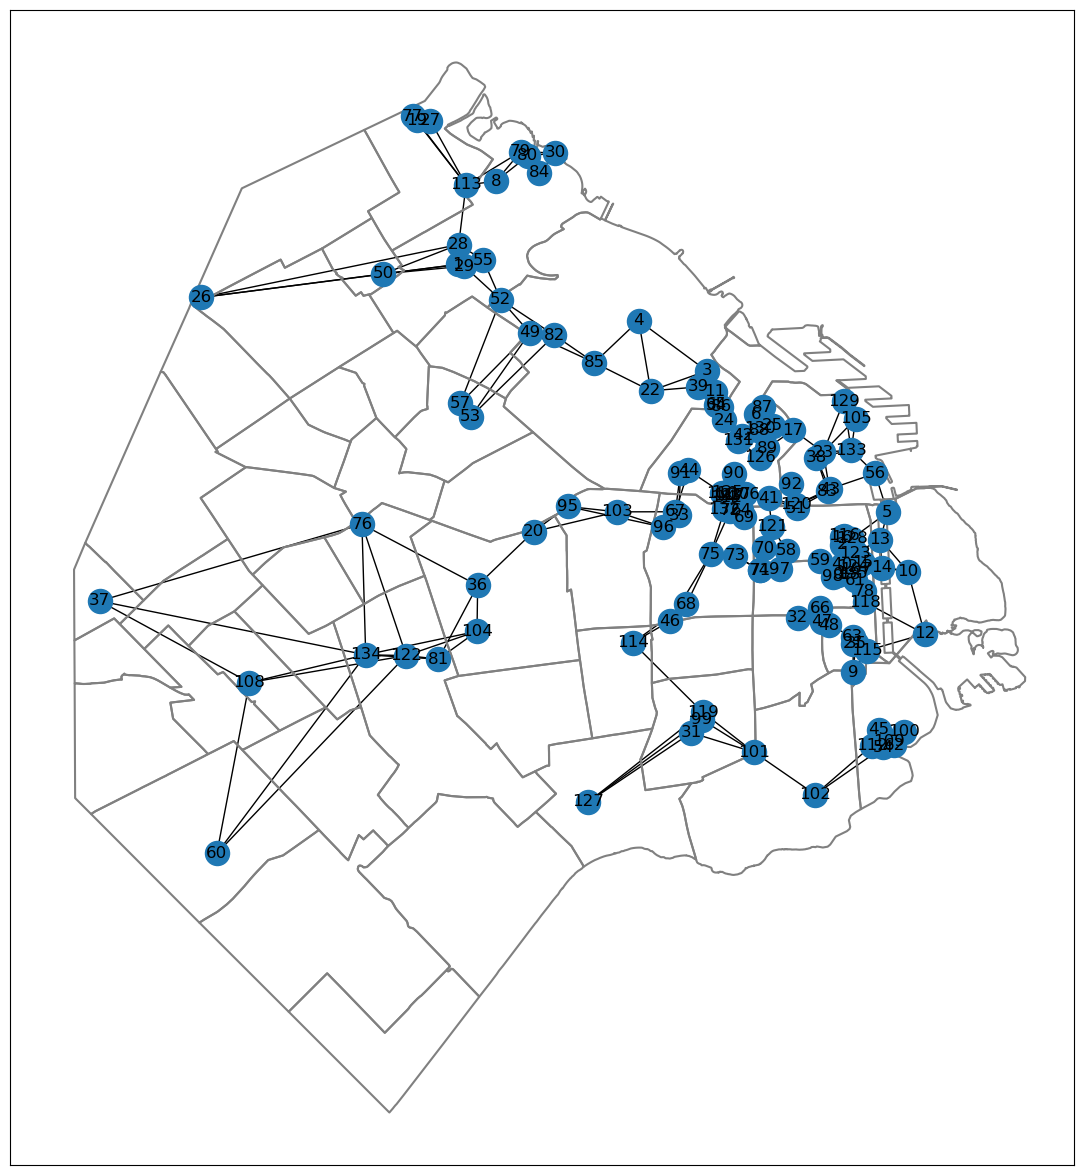

In [13]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Partiendo de la ecuación 3, tenemos:

$$
p = (1 - \alpha)Cp + \frac{\alpha}{N} \cdot \mathbf{1}
$$

Luego pasamos restando y tenemos:

$$
p - (1 - \alpha)Cp = \frac{\alpha}{N} \cdot \mathbf{1}
$$

Si factorizamos por $p$, sabiendo que $Ip = p$, tenemos:

$$
(I - (1 - \alpha)C)p = \frac{\alpha}{N} \cdot \mathbf{1}
$$


Multiplicamos a ambos lados por $\frac{N}{\alpha}$, pues $( \alpha \neq 0)$, y obtenemos:


$$
\frac{N}{\alpha}(I - (1 - \alpha)C)p = \mathbf{1}
$$

Que es justamente $Mp = b$

Por lo tanto, $p$ es solución de la ecuación $Mp = b$, con los $M$ y $b$ dados.


## Punto 2:


## Punto 3:

In [19]:
# Función que dado un vector de pageRanks p, un m y un alfa, hace un gráfico de los museos en CABA con los nodos de tamaño
# proporcional a su valor de page rank
def graficar(p, m, alfa):
    factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
    fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    pr = p # Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
    # pr = pr/pr.sum() # Normalizamos para que sume 1
    Nprincipales = 5 # Cantidad de principales
    principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
    labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
    ax.set_title(rf"Gráfico de Museos con tamaño por PageRank con $m={m}$ y $\alpha={alfa}$", fontsize=16)
    nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
    nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres
    return

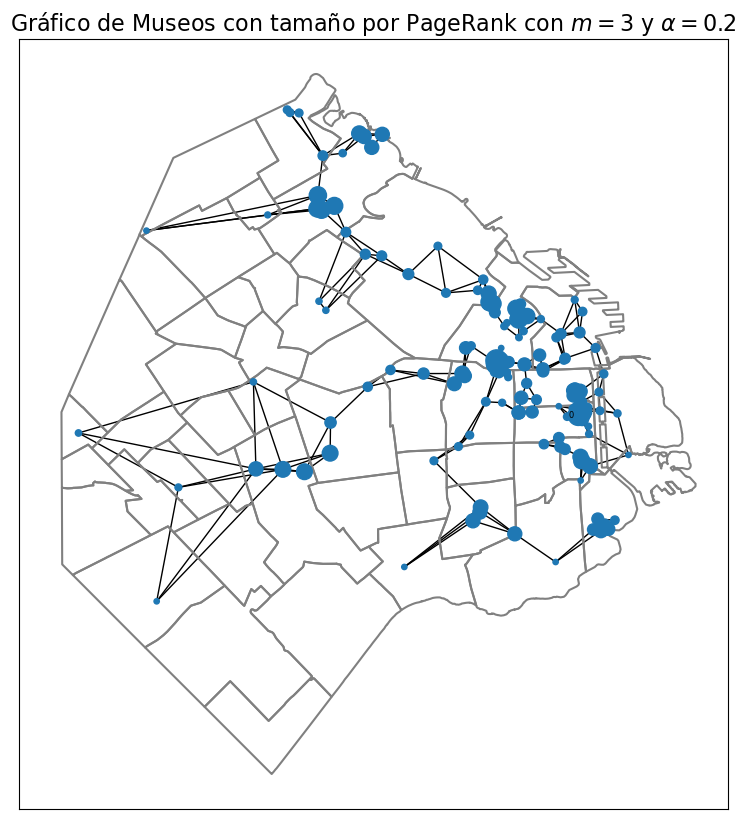

In [20]:
from template_funciones import *
# Punto a
alfa = 1/5
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)
p =calcula_pagerank(A, alfa)
graficar(p,m,alfa)

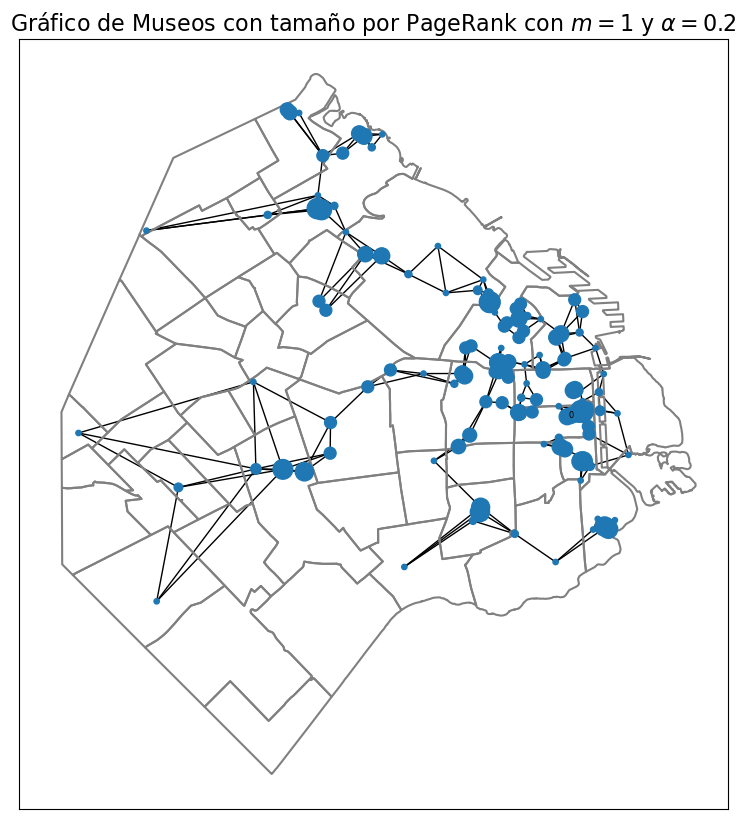

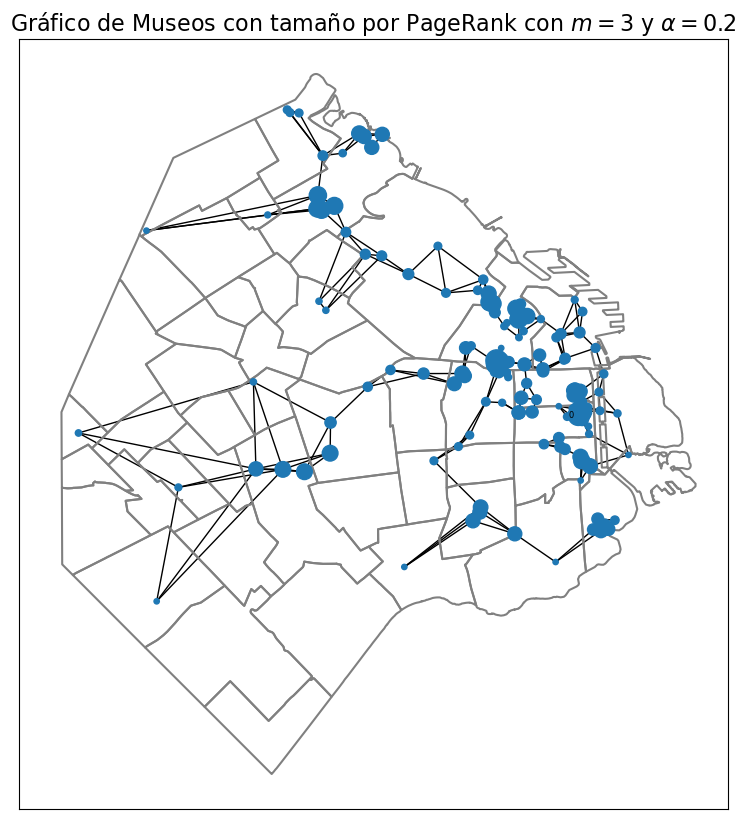

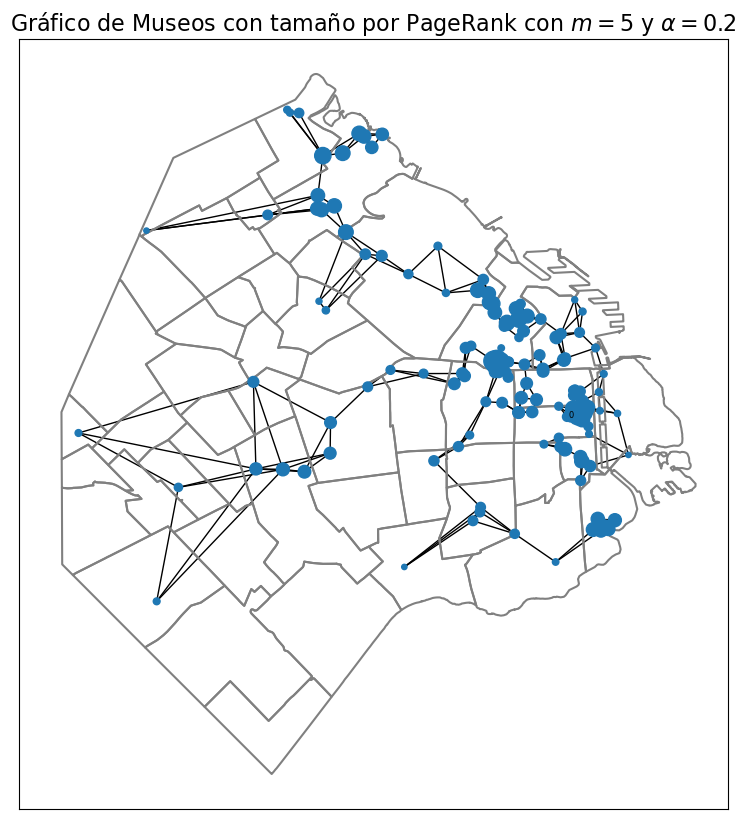

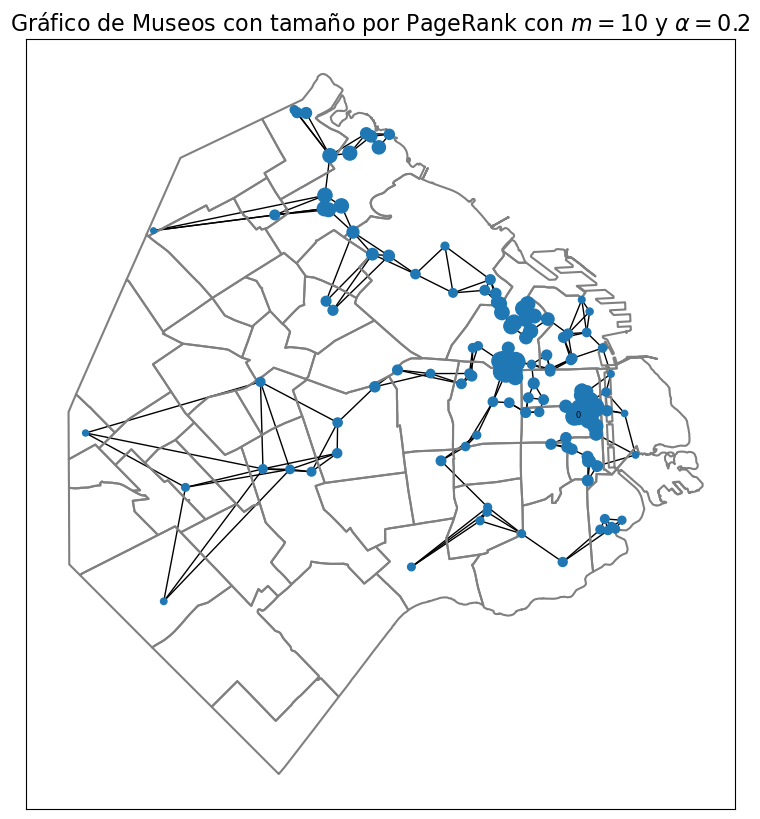

In [21]:
# Punto b
alfa = 1/5
M = [1,3,5,10]
for m in M:
    A = construye_adyacencia(D,m)
    p = calcula_pagerank(A, alfa)
    graficar(p, m, alfa)

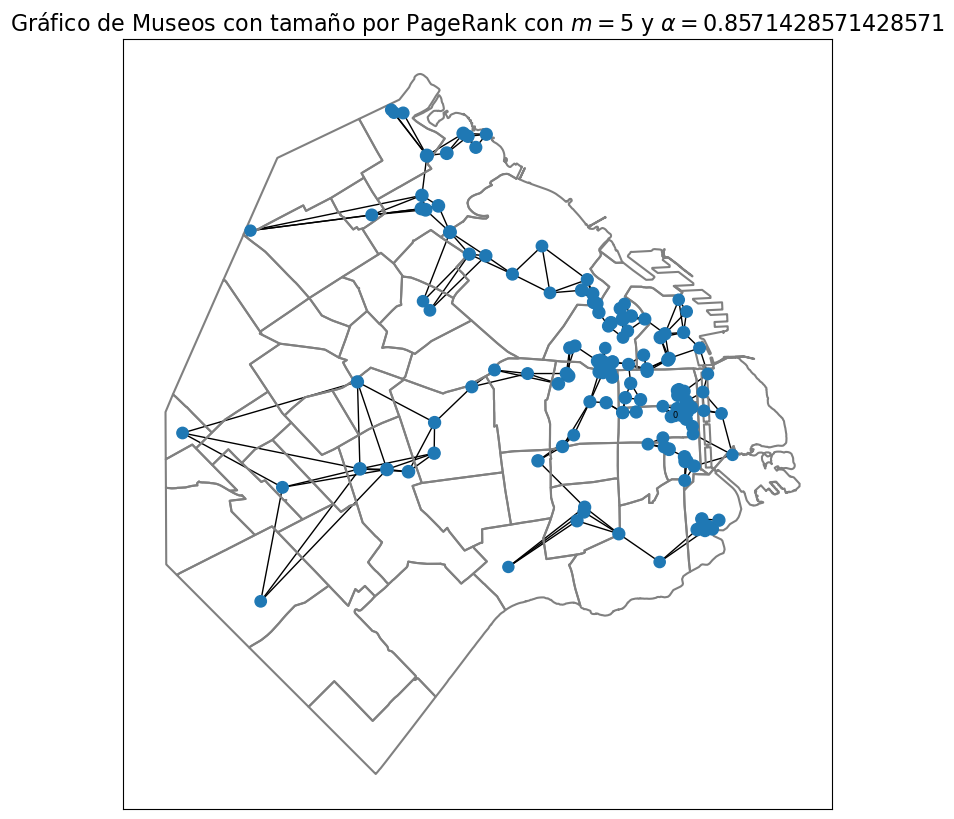

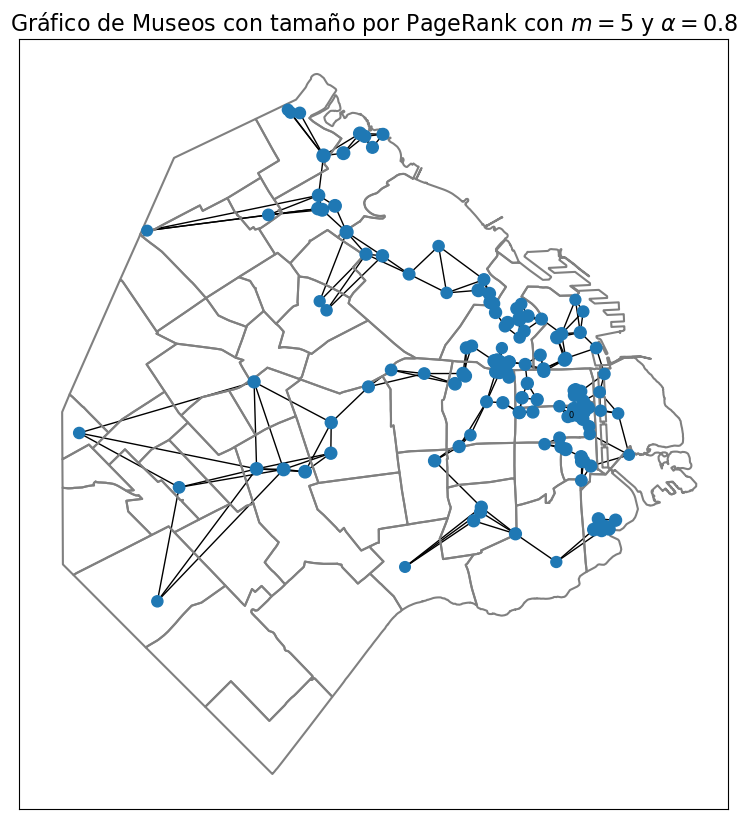

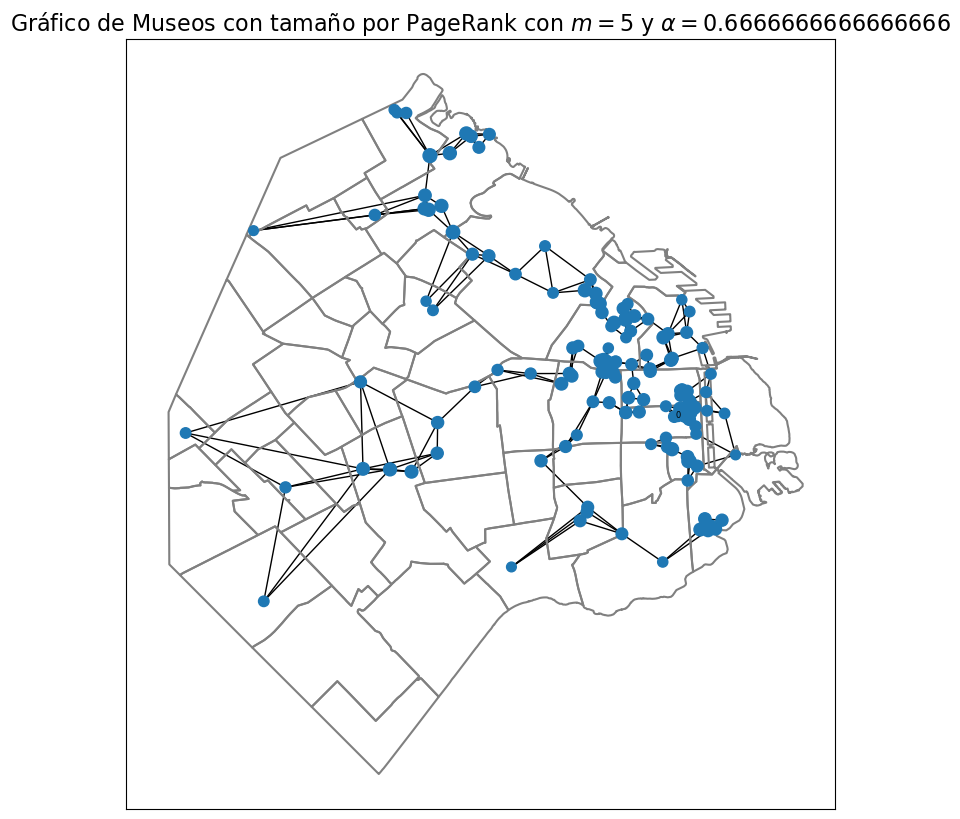

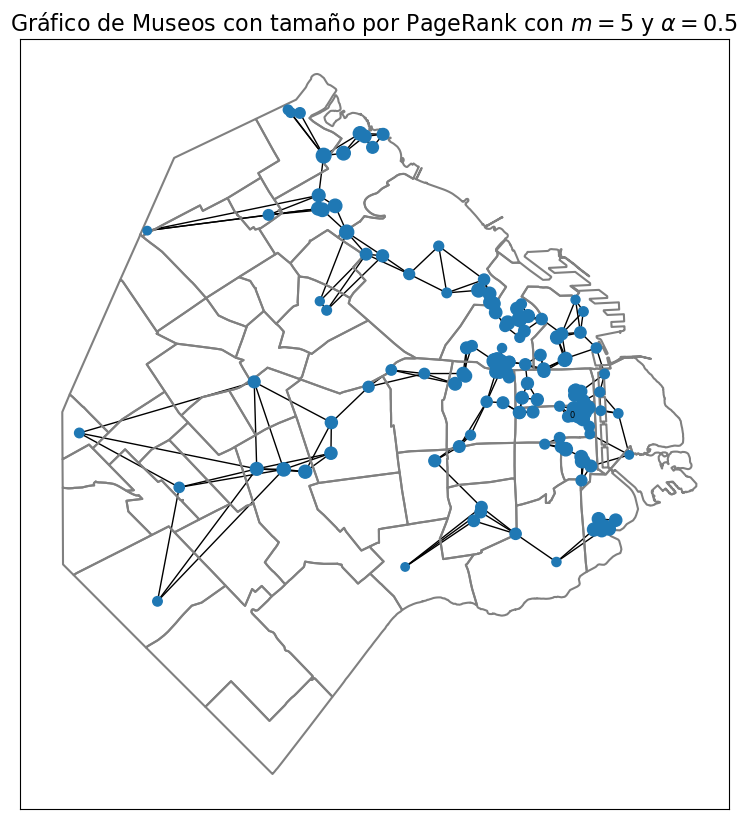

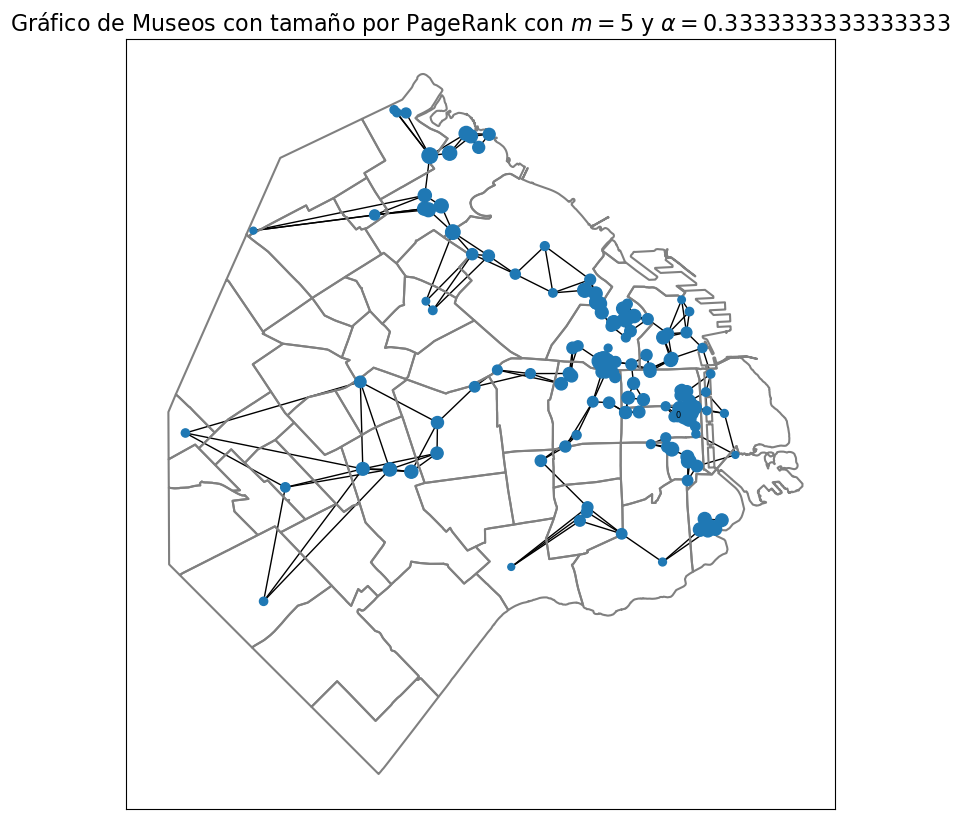

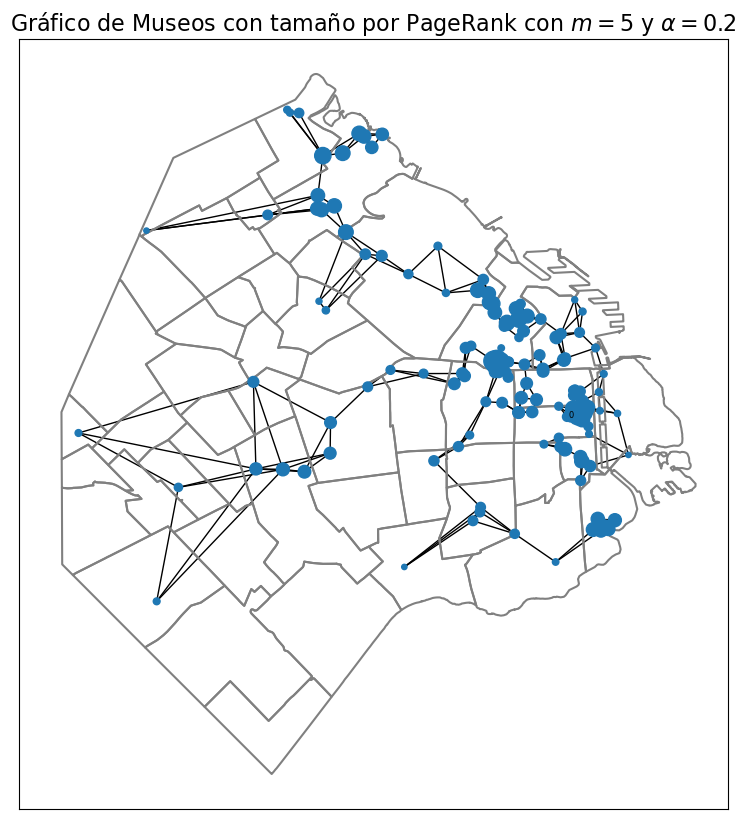

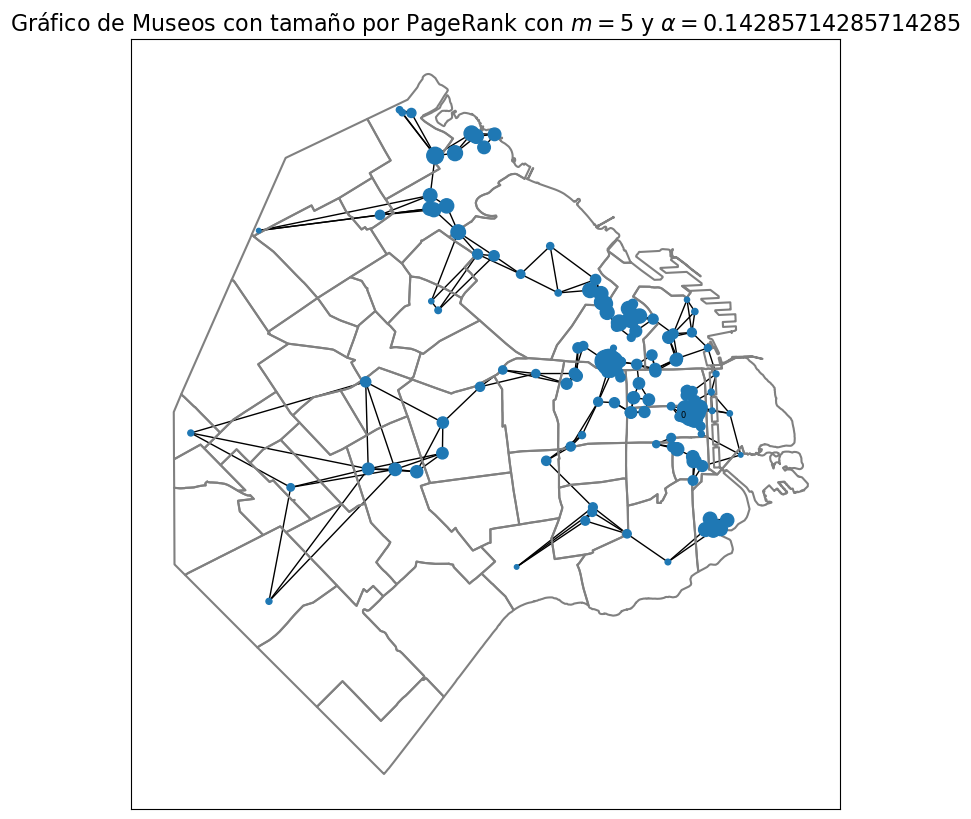

In [22]:
# Punto c
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
m = 5
for alfa in alphas:
    A = construye_adyacencia(D,m)
    p = calcula_pagerank(A, alfa)
    graficar(p, m, alfa)

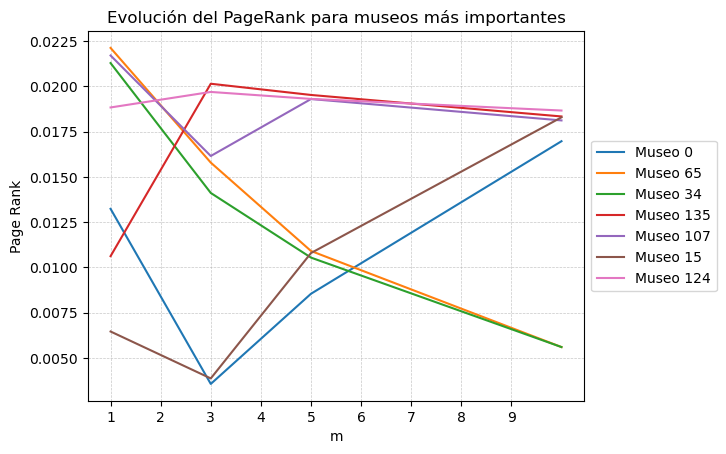

In [23]:
# Parte 2 - (a) - Variando m
M = [1,3,5,10]
size_M = len(M)
n = 3
alfa = 1/5

# Guardamos los valores del pagerank para cada museo para cada m ()
PR = [[0 for _ in range(len(D))] for _ in range(size_M)] 
for i in range(size_M):
    A = construye_adyacencia(D, M[i])
    p = calcula_pagerank(A, alfa)
    PR[i] = p

# Una vez que tenemos los valores calculados del pageRank para cada m, queremos obtener los 3 museos centrales para cada m dado (pueden no ser los mismos).
# Como maximo tenemos size_M * 3 museos distintos, que en este caso serían 12 museos como máximo. Estos son los que vamos a trackear su evolución
# para distintos valores de m.

principales_con_repetidos = [0 for _ in range(size_M*3)]

# --- TODO --- Tomo los 3 indices de los maximos por cada fila y los 
for i in range(0, size_M, 3):
    pcopy = PR[i].copy().flatten()
    top3_indices = np.argsort(pcopy)[-3:][::-1] # Sorteo de menor a mayor los valores de p[i] el vector de pageRank para m = M[i],
    # después tomo los indices de los 3 ultimos valores (mayores) y los revierto para que queden de mayor a menor.
    principales_con_repetidos[i] = top3_indices[0]
    principales_con_repetidos[i+1] = top3_indices[1]
    principales_con_repetidos[i+2] = top3_indices[2]

principales = set()
for elem in principales_con_repetidos:
    if elem not in principales:
        principales.add(elem)
principales_array = np.array(list(principales))

# Para saber los distintos valores de pageRank para distintas m de un mismo museo tengo que mirar las columnas de PR

cant_importantes = len(principales)
x = M
for i in range(cant_importantes):
    row = [0 for _ in range(size_M)]
    # Miro la columna dada por el indice de cada museo principal, 
    # esto me da sus distintos valores de page rank para distintas m.
    ind = principales_array[i] # Indice del museo que sabemos que es uno de los principales
    for j in range(size_M):
        row[j] = PR[j][ind]
    y = row
    plt.plot(x, y, label =f"Museo {ind}")
    
plt.title("Evolución del PageRank para museos más importantes")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("m")       # Eje X
plt.ylabel("Page Rank")           # Eje Y
plt.xticks(range(1, M[size_M-1], 1))
plt.show()

***Pregunta:*** *¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?*

***Respuesta:*** Si, hay museos que son relevantes con redes con pocas conexiones. Los museos se vuelven más o menos relevantes dependiendo del valor m (cantidad de conexiones). La prueba de esto es que hay más de 3 museos centrales cuando variamos m (es decir que para m's distintas los 3 museos de page rank más alto son distintos). 

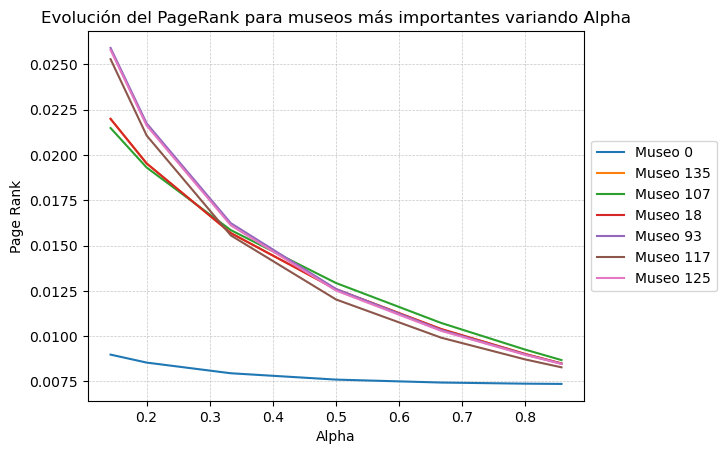

In [25]:
# Parte 2 - (b) - Variando alfa
n = 3
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
size_alphas = len(alphas)
m = 5

# Guardamos los valores del pagerank para cada museo para cada m ()
PR = [[0 for _ in range(len(D))] for _ in range(size_alphas)] 
for i in range(size_alphas):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alphas[i])
    PR[i] = p

# Una vez que tenemos los valores calculados del pageRank para cada m, queremos obtener los 3 museos centrales para cada m dado (pueden no ser los mismos).
# Como maximo tenemos size_alphas * 3 museos distintos, que en este caso serían 12 museos como máximo. Estos son los que vamos a trackear su evolución
# para distintos valores de m.

principales_con_repetidos = [0 for _ in range(size_alphas*3)]

# --- TODO --- Tomo los 3 indices de los maximos por cada fila y los 
for i in range(0, size_alphas, 3):
    pcopy = PR[i].copy().flatten()
    top3_indices = np.argsort(pcopy)[-3:][::-1] # Sorteo de menor a mayor los valores de p[i] el vector de pageRank para m = M[i],
    # después tomo los indices de los 3 ultimos valores (mayores) y los revierto para que queden de mayor a menor.
    principales_con_repetidos[i] = top3_indices[0]
    principales_con_repetidos[i+1] = top3_indices[1]
    principales_con_repetidos[i+2] = top3_indices[2]

principales = set()
for elem in principales_con_repetidos:
    if elem not in principales:
        principales.add(elem)
principales_array = np.array(list(principales))

# Para saber los distintos valores de pageRank para distintas m de un mismo museo tengo que mirar las columnas de PR

cant_importantes = len(principales)
x = alphas
for i in range(cant_importantes):
    row = [0 for _ in range(size_alphas)]
    # Miro la columna dada por el indice de cada museo principal, 
    # esto me da sus distintos valores de page rank para distintas m.
    ind = principales_array[i] # Indice del museo que sabemos que es uno de los principales
    for j in range(size_alphas):
        row[j] = PR[j][ind]
    y = row
    plt.plot(x, y, label =f"Museo {ind}")
    
plt.title("Evolución del PageRank para museos más importantes variando Alpha")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Alpha")       # Eje X
plt.ylabel("Page Rank")           # Eje Y
plt.show()

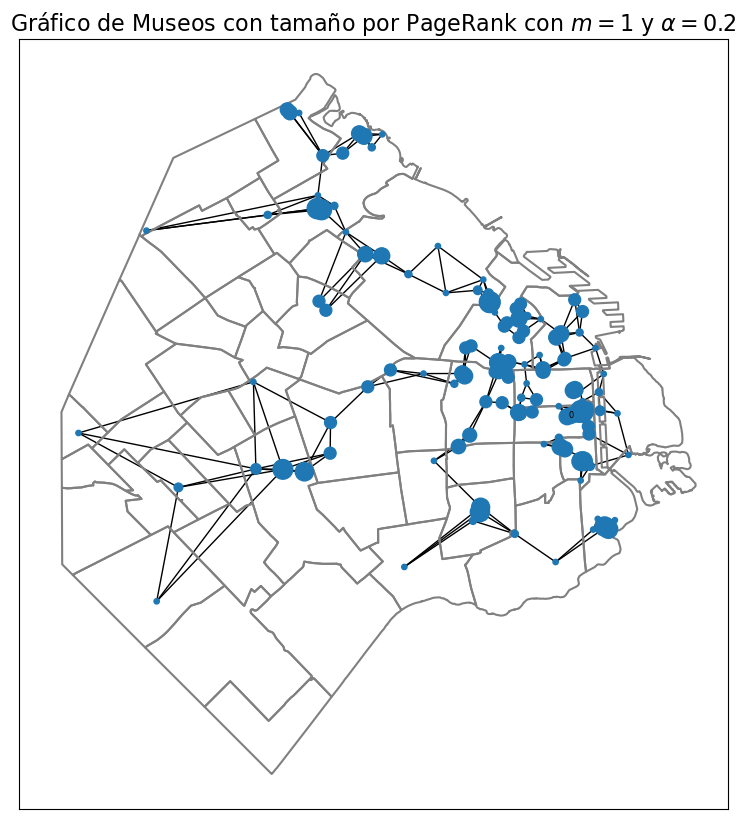

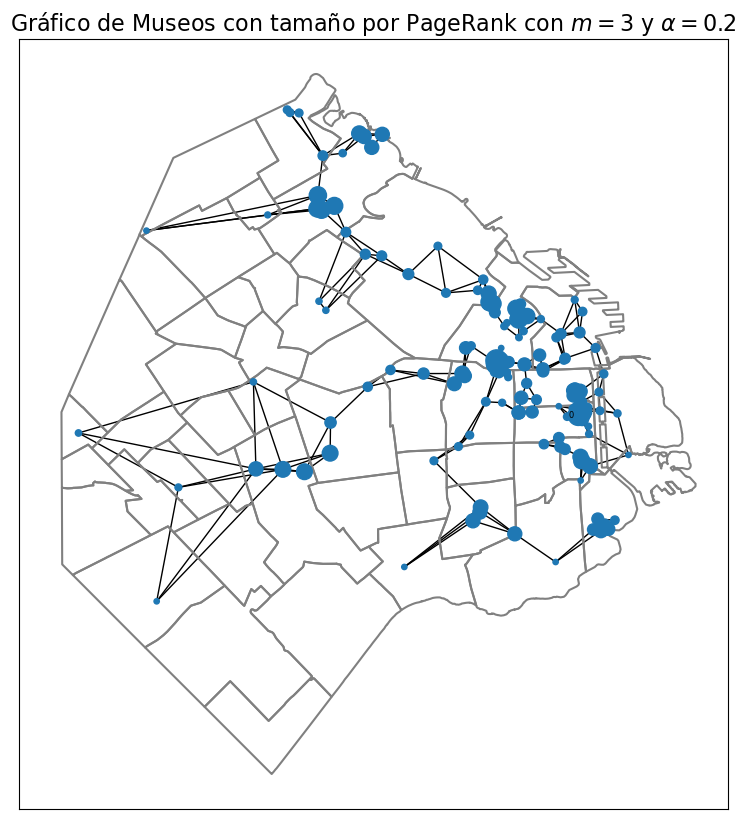

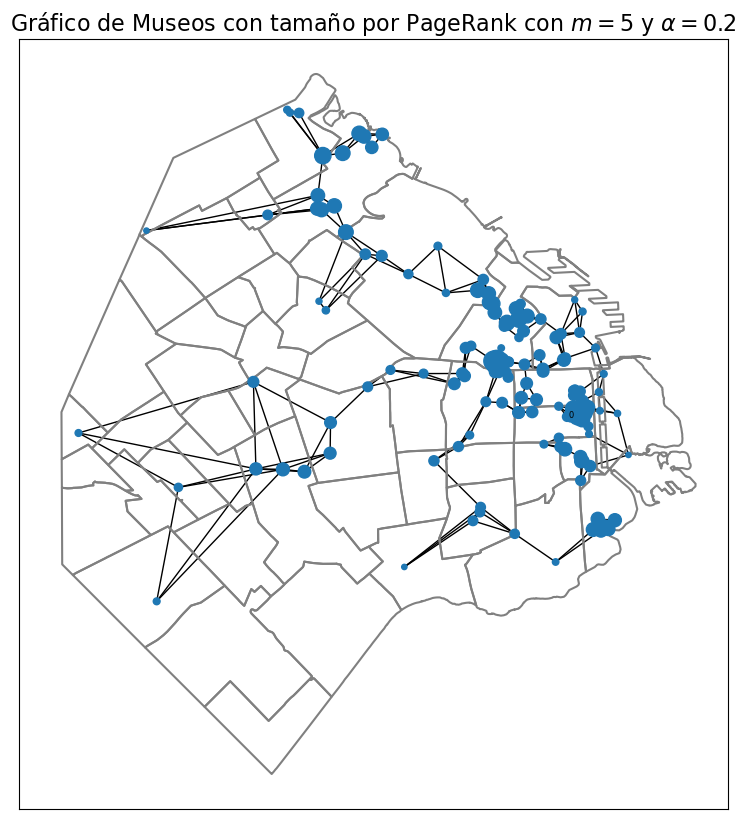

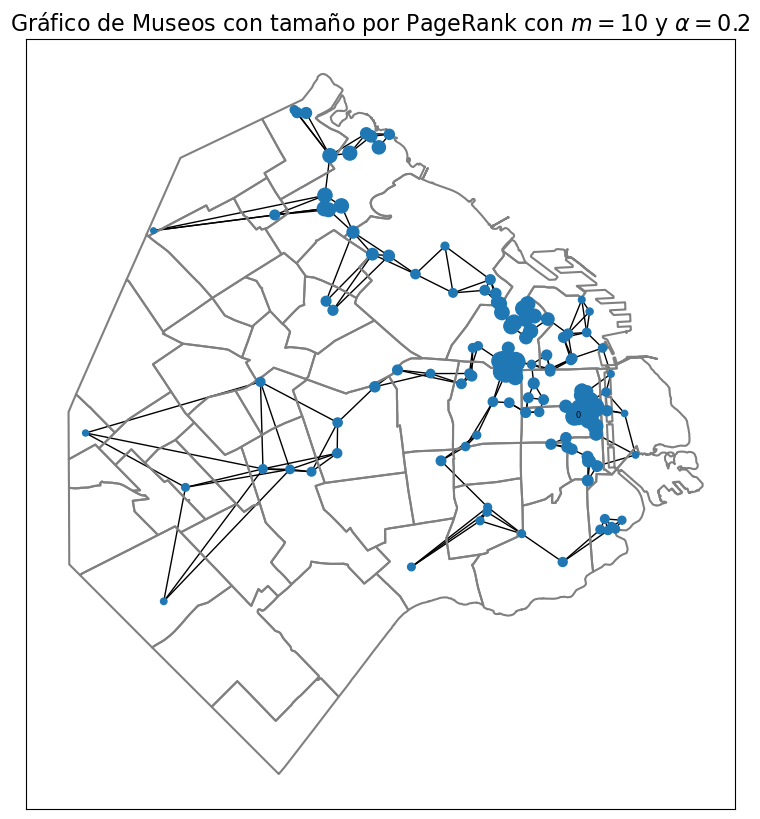

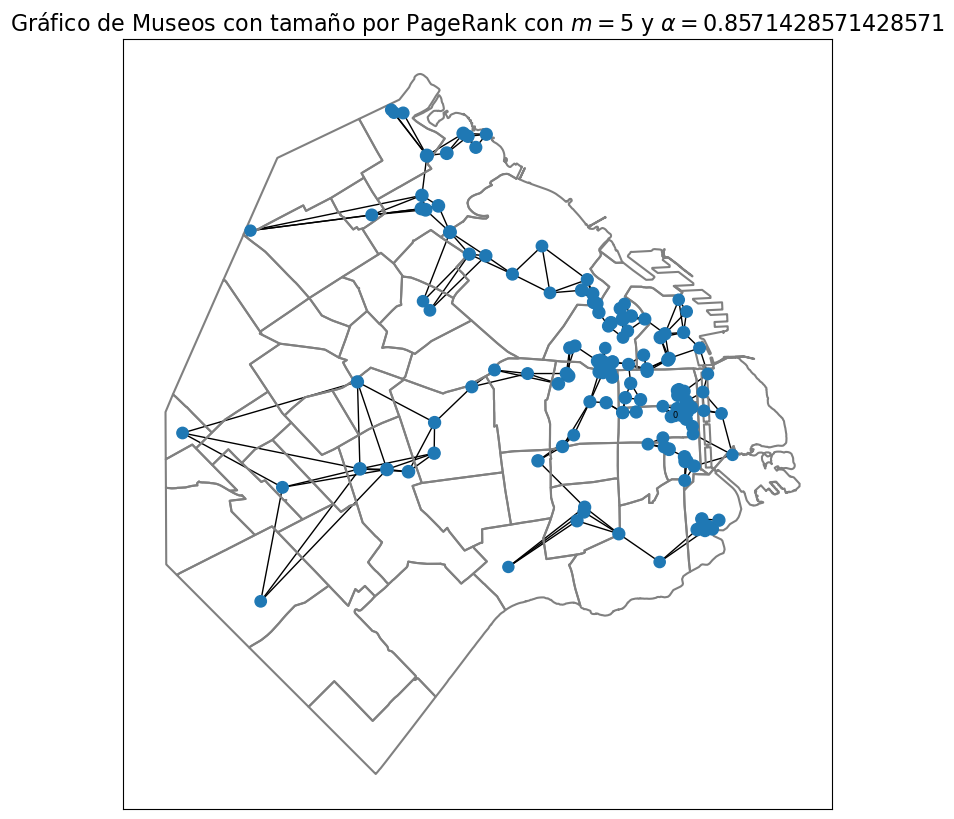

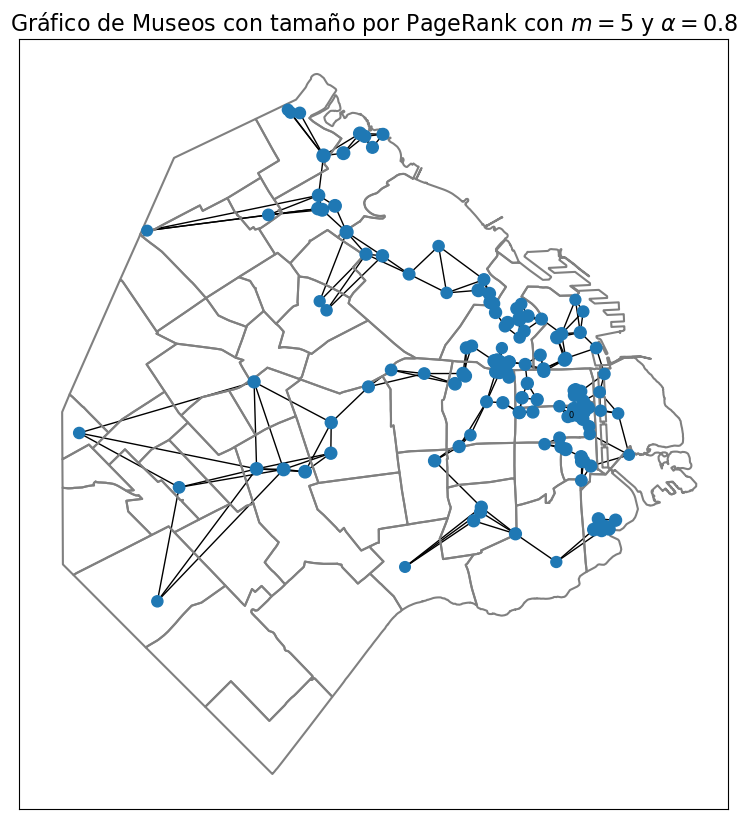

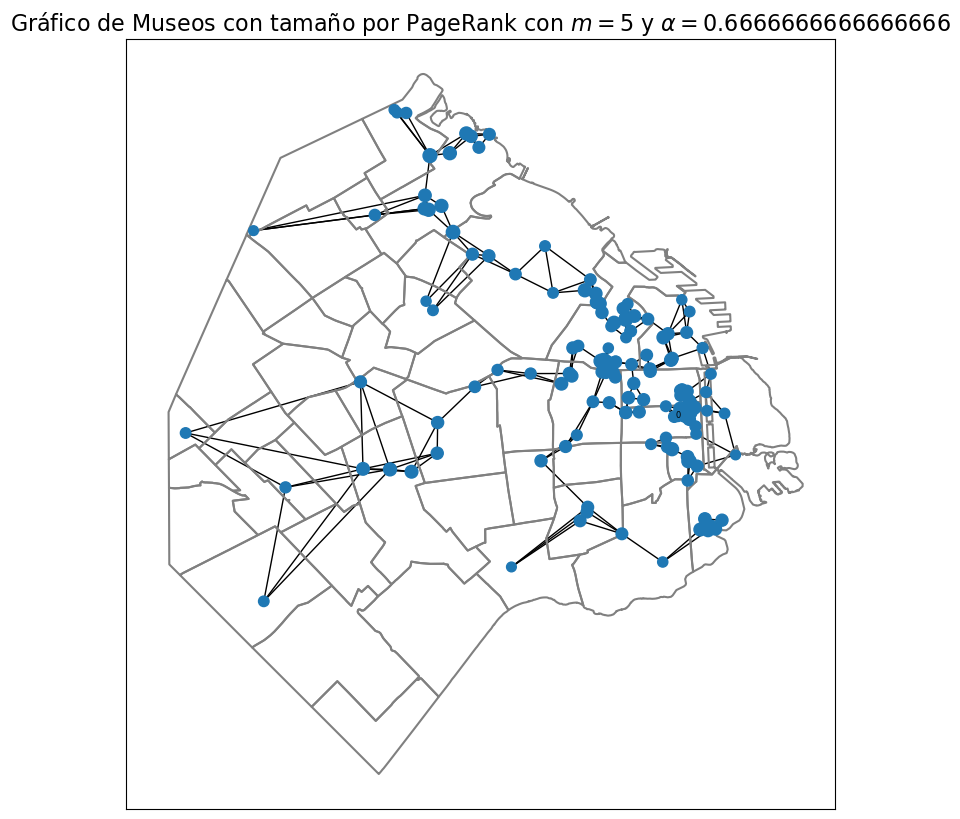

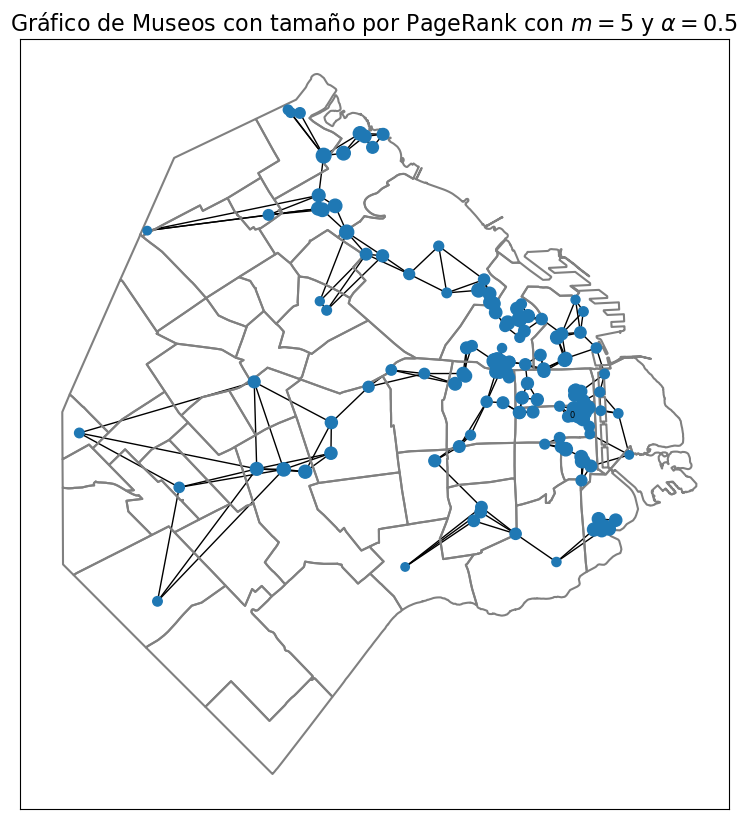

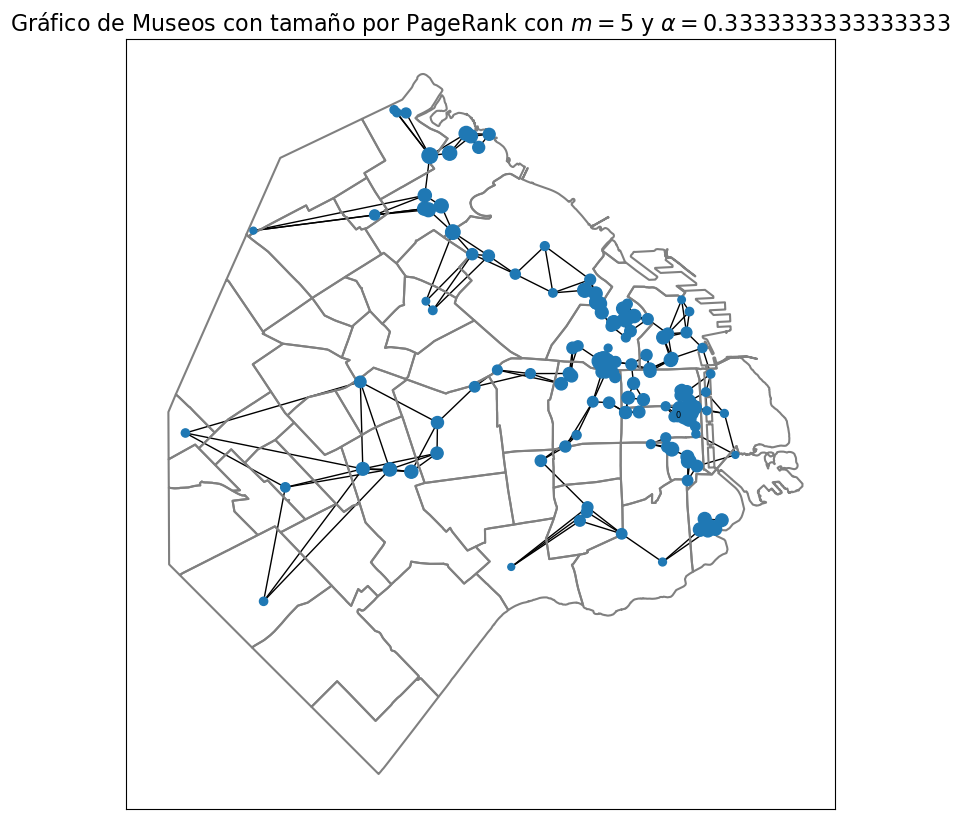

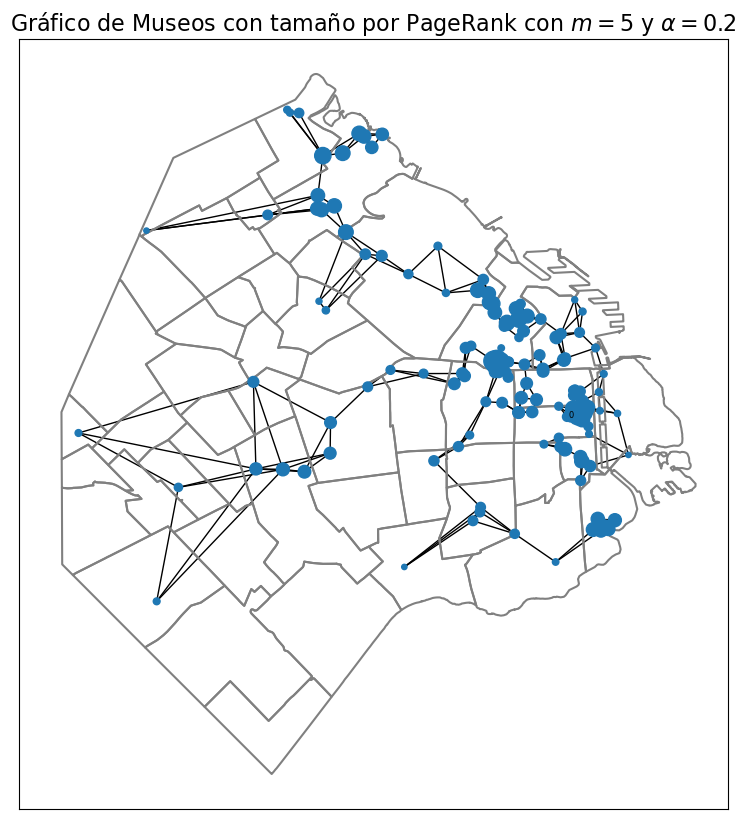

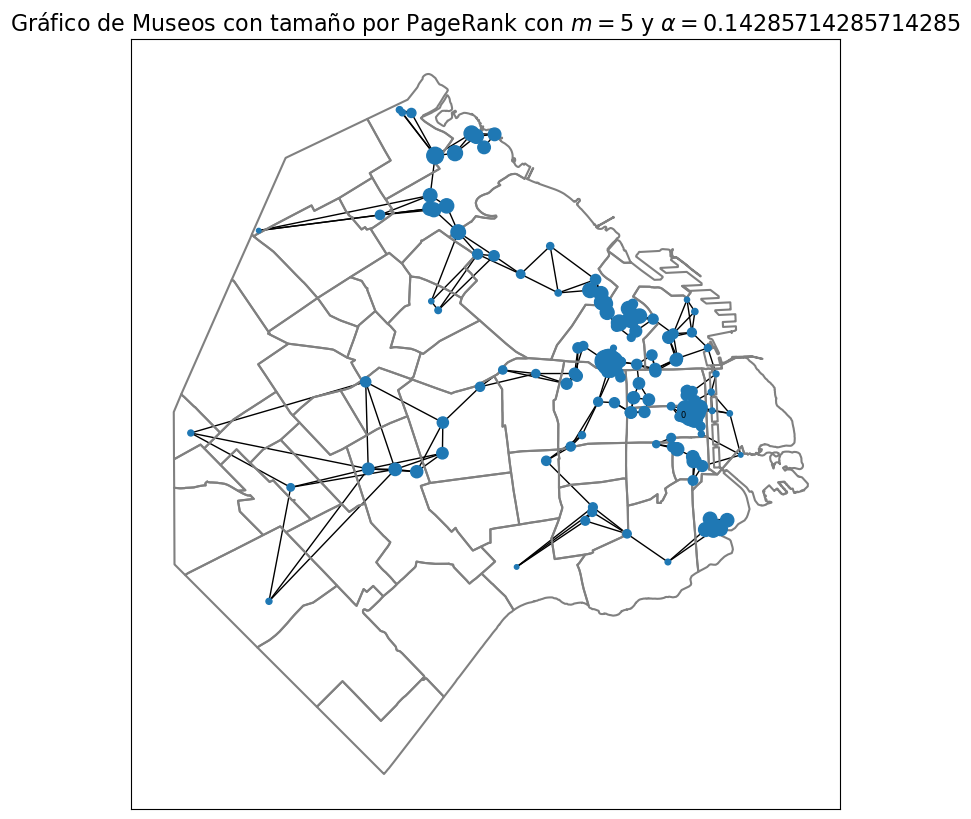

In [26]:
# Punto 3 - Parte II - (b)
M = [1,3,5,10]
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
alfa = 1/5
for m in M:
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alfa)
    graficar(p, m, alfa)
m = 5
for alpha in alphas:
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alpha)
    graficar(p, m, alpha)
    


***Pregunta:*** *¿Qué regiones se vuelven más predominantes al aumentar α? ¿Y al aumentar m?*

***Respuesta:*** Al aumentar o disminuir alpha, todos los museos ven afectado su pageRank de manera proporcional, pero esto afecta más a los que tengan más pageRank. Es decir, crece más el pageRank de un museo que tenía un valor base alto al aumentar alpha, y disminuye más al disminuirlo. Al aumentar m, las zonas céntricas se vuelven más relevantes porque tienen más conexiones cercanas, mientras que las zonas más alejadas del centro se vuelven menos relevantes.

## Punto 4:

Partimos de la ecuación:

$$
\mathbf{v} = B^{-1} \cdot \mathbf{w}
$$

Esto es equivalente a:

$$
B \cdot \mathbf{v} = \mathbf{w}
$$

con $B$ inversible. Pero como sabemos que

$$
B = \sum_{k=0}^{r-1} C^k,
$$

entonces:

$$
\left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v} = \mathbf{w}
$$

lo que equivale a:

$$
(I + C + C^2 + C^3 + \dots + C^{r-1}) \cdot \mathbf{v} = \mathbf{w}
$$

---

Queremos ver que si cada persona realiza $r$ visitas y empieza en un museo dado (determinado por el vector $v$, el total de visitas recibidas por cada museo queda almacenado en $w$, y está dado por:

$$
\mathbf{w} = \left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v}
$$

   Después de $k$ pasos, la distribución esperada de visitantes es $C^k \cdot \mathbf{v}$, con $C$ la matriz de transiciones. Entonces, el total de visitas será la suma de estas distribuciones desde $k = 0$ hasta algún paso dado (en este caso hasta $r-1$).  
   Esto se debe a que en cada paso se visitan museos: el paso 0 lo determina el vector $v$, que representa la posición inicial de las personas en los museos. Luego, al dar un paso, se mueven según la matriz de transición $C$ y visitan otros museos. En el paso $r$, se habrán movido $r - 1$ pasos, donde cada movimiento aporta visitas a las visitas totales representadas por $w$.

De esta forma:

$$
\mathbf{w} = I\mathbf{v} + C\mathbf{v} + C^2\mathbf{v} + \dots + C^{r-1}\mathbf{v} = \left( \sum_{k=0}^{r-1} C^k \right) \cdot \mathbf{v} = B\mathbf{v}
$$

con el $B$ definido anteriormente.

   Sabemos que $B$ es inversible porque $C$ es inversible (lo demostramos en el punto 2). En particular, como $C$ es irreducible y aperiódica, se concluye que:

$$
I + C + C^2 + \dots + C^{r-1}
$$

es **positiva definida** (ya que $C$ es estocástica y no tiene una estructura patológica como nodos absorbentes o ciclos aislados).


## Punto 5:

In [31]:
cantidad_de_visitas = 3
w = np.loadtxt("visitas.txt") # Cargo el vector w dado por el archivo visitas.txt

C = calcula_matriz_C_continua(D)
B = calcula_B(C,cantidad_de_visitas)
L, U = calculaLU(B)
# Dado Bv = w, tengo w y B, quiero calcular v
# Ly = w
# Ux = v
# Ax = b
# Resolvemos Bv = w mediante LU
# Ly = w
y = np.linalg.solve(L, w)

#  Uv = y
v = np.linalg.solve(U, y)

print(v)

[1159. 1078. 1137. 1073. 1097. 1083. 1096. 1088. 1126. 1083. 1151. 1105.
 1110. 1102. 1110. 1170. 1084. 1120. 1120. 1106. 1160. 1146. 1073. 1087.
 1056. 1113. 1149. 1082. 1088. 1053. 1115. 1115. 1146. 1133. 1137. 1090.
 1092. 1031. 1085. 1103. 1077. 1128. 1172. 1116. 1130. 1085. 1013. 1173.
 1120. 1081. 1116. 1052. 1118. 1070. 1087. 1089. 1125. 1034. 1105. 1124.
 1117. 1090. 1103. 1163. 1076. 1086. 1063. 1138. 1120. 1085. 1053. 1105.
 1128. 1094. 1084. 1123. 1052. 1070. 1069. 1119. 1194. 1085. 1124. 1089.
 1101. 1090. 1096. 1176. 1115. 1061. 1134. 1049. 1097. 1069. 1068. 1081.
 1094. 1075. 1110. 1129. 1115. 1086. 1083. 1128. 1097. 1124. 1100. 1118.
 1073. 1121. 1127. 1126. 1086. 1073. 1060. 1083. 1077. 1037. 1072. 1046.
 1161. 1138. 1104. 1108. 1086. 1081. 1094. 1131. 1116. 1116. 1168. 1115.
 1110. 1118. 1156. 1124.]


## Punto 6:

Para calcular el número de condición de $B$ en norma 1, tenemos que calcular las normas de $B$ y de su inversa. Es decir:

$$
\text{cond}_1(B) = \|B\|_1 \cdot \|B^{-1}\|_1
$$

Sabemos que la norma 1 de $B$ es la mayor suma absoluta de las columnas de $B$. Ahora bien, sea:

$$
B = \sum_{k=0}^{r-1} C^k
$$

Cada elemento de $B$ es la suma de los elementos de $C^k$ para $k$ desde 0 hasta un cierto $r$ dado. Como $C$ es estocástica (las columnas suman 1), también lo es cada $C^k$, ya que esta propiedad se conserva bajo potencias.

Entonces, en cada sumando de la sumatoria, el valor máximo de la suma de alguna de sus columnas es 1. Dado que hay $r$ sumandos (la identidad también cumple $||I||_1 = 1$), se tiene:

$$
\|B\|_1 = \left\| \sum_{k=0}^{r-1} C^k \right\|_1 = \sum_{k=0}^{r-1} \|C^k\|_1
$$

Dado que todos los elementos de $C$ son positivos, lo cual se preserva en cada $C^k$.

Como $C^k$ es estocástica para todo $k \geq 0$, se cumple que:

$$
\sum_{k=0}^{r-1} \|C^k\|_1 = \sum_{k=0}^{r-1} 1 = r
$$

Por lo tanto:

$$
\|B\|_1 = r
$$

Y entonces tenemos que el número de condición de B es:
$$
\text{cond}_1(B) = r \cdot \|B^{-1}\|_1
$$

In [107]:
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    B = np.eye(C.shape[0]) # B = I
    r = cantidad_de_visitas
    C_k = C # C_k = C^1
    for k in range(1, r):
        # Sumamos las matrices de transición para cada cantidad de pasos
        B = B + C_k # B = B + C^k
        C_k = C_k @ C
    return B

# Calculo de número de condición de B
def norma1(A):
    max = 0
    for c in range(len(A)):
        col_sum = 0
        for f in range(len(A)):
            col_sum = col_sum + A[f][c]
        if(col_sum > max):
            max = col_sum
    return max

def condB(B, r): # Calcula el número de condición de la matriz B con r conocido
    # cond(B) = ||B|| * ||B^-1||
    # ||B|| = r
    B_inv = inversa(B)
    norma_inv = norma1(B_inv)
    return r * norma_inv

cantidad_de_visitas = 3
C = calcula_matriz_C_continua(D)
B = calcula_Bc(C,cantidad_de_visitas)
print(f"Número de condición de B para r={cantidad_de_visitas}:", condB(B, cantidad_de_visitas))

Número de condición de B para r=3: 1.03078364312283


La cota del error relativo en norma 1 viene dada por:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$


Y sabemos que $||B||_1 = r$, entonces tenemos:
$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq r * ||B^-1||_1\cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

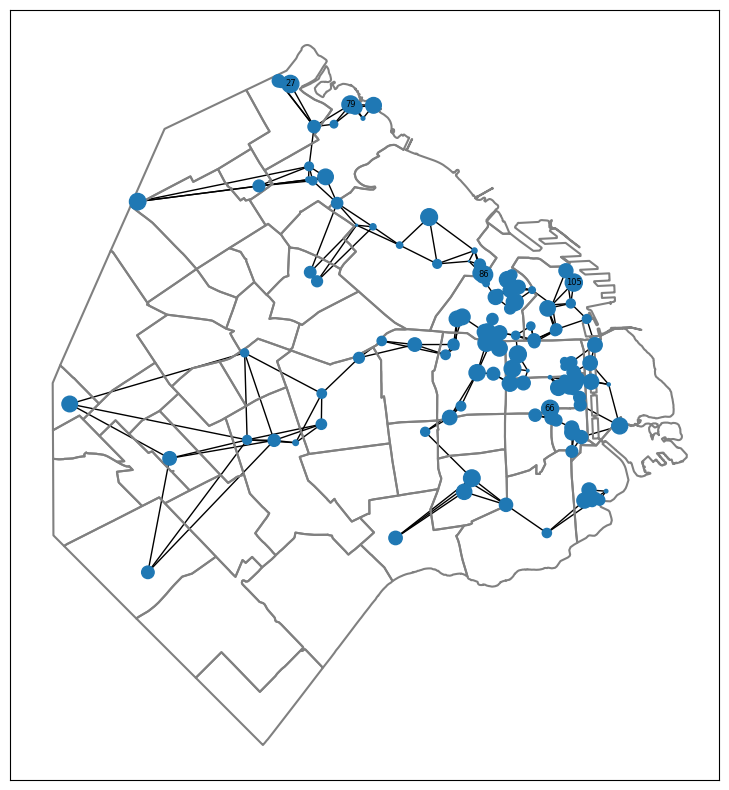

In [36]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres